# SAG Test Project
## The Tasks

* Become familiar with the basic working principle of a SAG mill
* Become familiar with the provided data
* Select a model to predict performance variables 5 minutes in advance
* Implement a prototype of this model to generate results
* Use the test data to calculate prediction error statistics and compare them to the baseline provided in baseline.ipynb
* Present your model and results to the team

Initial information provided states that there is 4 months of data of 3 types:

*   Performance variables:
    * Power Draw (MW) — Power drawn by the mill motor
    * Bearing Pressure (kPa) — Pressure on the mill supports. Can be thought of as the weight of the mill.


*   Control variables:
    *   Speed (RPM) — Rotation speed of the mill
    *   Conveyor Belt Feed Rate (t/h) — Mass flow rate of material into the mill
    *   Dilution Flow Rate (m³/h) — Volume flow rate of water into the mill


*   Feed variables:
    *   Conveyor Belt Fines (%) — Percent of material in the feed classified as "fine"

The goal is to predict the performance variables 5 minutes in the future. In this case, our features are all 6 variables at 5 min (and further) in the past.

## Initial Thoughts

* All of the control variables are controlled by the operator; thus, the task for this project is essentially predicting how the system will be performing in the future based on the current performance and how the operator will respond to this based on their previous responses.

* Assumedly, the data will be of a time-series format with some regular interval length.
* The problem is a supervised one with a set goal of a 5 minute future interval prediction (a sliding window):

    * Examples of models that could be used:
    
        * Neural Networks, e.g. Recurrent Neural Network(RNN).
        * 
        
* External conditions may change over time meaning there could be localised changes.
* 

The first step to be completed shall be the Exploratory Data Analysis.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

 Load data for examination. A quick look at format of table tells us it's comma-delimited.

In [3]:
# Read csv table into pandas dataframe.
df_train = pd.read_csv("../../../data/sag_data_train.csv")

# Check head and tail.
df_train

,Time,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
0,2015-09-15T00:00:00,5488.175540,11.737357,7.843532,1030.590108,2935.660276,38.641018
1,2015-09-15T00:01:00,5423.930126,11.543755,7.681607,1039.869847,2928.333772,45.243656
2,2015-09-15T00:02:00,5502.058523,11.169525,7.514173,1033.237205,2919.128115,38.716221
3,2015-09-15T00:03:00,5477.862749,11.035091,7.592248,1035.075573,2985.500811,42.860703
4,2015-09-15T00:04:00,5508.013201,11.418827,7.784895,1042.189406,2905.052105,50.524544
...,...,...,...,...,...,...,...
138236,2015-12-19T23:56:00,5291.038653,13.661863,8.709156,943.244733,2876.678675,50.263821
138237,2015-12-19T23:57:00,5306.966515,13.610935,8.603212,976.361162,2813.859524,44.921227
138238,2015-12-19T23:58:00,5260.321858,13.392879,8.405826,932.982467,2877.573304,40.478775
138239,2015-12-19T23:59:00,5244.054889,13.103755,8.239607,951.282578,2882.385391,47.955658


There are 7 columns of data, 6 that have been mentioned previously with the 7th being the time column, with the values given in a datetime format. We can reformat the table now with the time column as the index.

This time column indicates that there has been a reading taken at constant 1 minute intervals. This would indicate the recordings were not stopped for 4 months straight, potentially meaning the machine was also running for this time.


In [4]:
# Check for any null values
print(df_train.isnull().sum())

Time                             0
Bearing Pressure (kPa)           1
Power Draw (MW)                  1
Speed (RPM)                      0
Dilution Flow Rate (m3/h)        2
Conveyor Belt Feed Rate (t/h)    2
Conveyor Belt PSD Fines (%)      2
dtype: int64


These null values indicate that there is a mismatch in length of valid values for each column. However, there are 128241 rows and for each column there are at most 2 null values, which is statistically insignificant. However, this doesn't confirm whether there are any discontinuities in the time series.

For this, it may be considered reasonable to use:

$\\ $

$$ N_{MissingValues} =   \frac{t_{start} - t_{end}}{t_{interval}} - n_{rows} $$
 
$\\ $


However, nothing is known about how the data was recorded, and thus the intervals are not guaranteed to be regular. So, to be completely certain, a full series of boolean values will be created and checked.

In [5]:
# Reformat the dataframe using the time column, parsed as date-time, as the index.
df_train = pd.read_csv("../../../data/sag_data_train.csv", index_col="Time", parse_dates=True)

df_train

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-09-15 00:00:00,5488.175540,11.737357,7.843532,1030.590108,2935.660276,38.641018
2015-09-15 00:01:00,5423.930126,11.543755,7.681607,1039.869847,2928.333772,45.243656
2015-09-15 00:02:00,5502.058523,11.169525,7.514173,1033.237205,2919.128115,38.716221
2015-09-15 00:03:00,5477.862749,11.035091,7.592248,1035.075573,2985.500811,42.860703
2015-09-15 00:04:00,5508.013201,11.418827,7.784895,1042.189406,2905.052105,50.524544
...,...,...,...,...,...,...
2015-12-19 23:56:00,5291.038653,13.661863,8.709156,943.244733,2876.678675,50.263821
2015-12-19 23:57:00,5306.966515,13.610935,8.603212,976.361162,2813.859524,44.921227
2015-12-19 23:58:00,5260.321858,13.392879,8.405826,932.982467,2877.573304,40.478775


In [6]:
# Check for missing time intervals by creating a list of boolean values

# Define funciton to generate list
from datetime import date, datetime, timedelta
def datetime_interval_list(start, end, interval):

    datetime_list = []
    next_time = start
    n = 0

    while next_time <= end:
        datetime_list.append(next_time)
        next_time += interval
    return datetime_list
    

In [7]:
# Create list of possible date time values
all_possible_datetimes = datetime_interval_list(datetime(2015, 9, 15, hour=0, minute=0, second=0), datetime(2015, 12, 20, hour=0, minute=0, second=0), timedelta(minutes=1))

missing_intervals = []

for i, j in zip(all_possible_datetimes, df_train.index):
    missing_intervals.append(not i == j)

# Convert to pandas series for panda method use
missing_intervals = pd.Series(missing_intervals)

print(missing_intervals.describe(), '\n')

print('Missing values: ', (missing_intervals).sum(),"\n")

count     138241
unique         1
top        False
freq      138241
dtype: object 

Missing values:  0 



Now it is certain that the data is a time series of 1 min datetime intervals with no discontinuities.

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>],
      dtype=object)

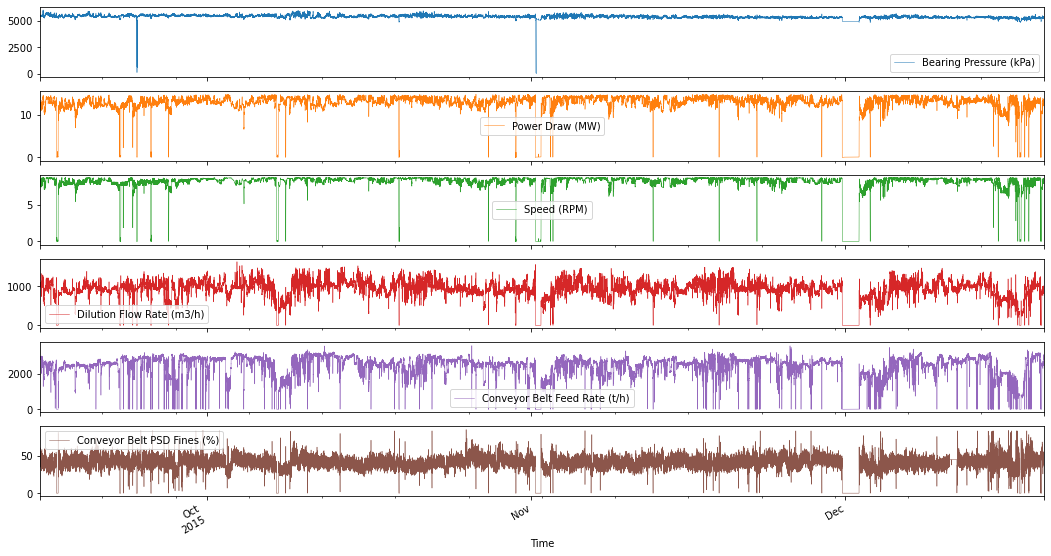

In [8]:
# Plot data for greater understanding
df_train.plot(figsize=(18, 10), subplots=True, lw=0.5)

* Data is very noisy.
* A lot of the large dips within each feature coincide with the large drops in other features.
    * Bearing Pressure has far fewer than the rest.
    * Conveyer Belt Feed Rate has far more.
    * Potentially these are occurances of powering down/breakdowns/power outages/etc.
        * Bearing pressure having fewer would indicate the machine was not emptied during some of these instances.
        * Conveyer Belt Feed Rate having more also makes sense since the material could have periods where it isn't being supplied while the machine is running.
            * Also could be powered down/breakdown independently of the machine.
* All features seem flat relative to these large drops.
    * y-axis could be readjusted to get a better look at trends ouotside of the drops.

The large number of intervals over the large timeframe contribute to the noise. In order to get a clearer picture of any trends the data could be resampled or we could look at a smaller timeframe. Resampling will be tried first to get an overall idea of the data. This could be done by taking the mean/median of each interval or by simply removing every 2nd, 3rd, etc. rows. The former would reduce the information loss, while the latter keeps original data untouched and stays in line with the nature of how the data was gathered in the first place (original dataset has data sampled at 1 min intervals.)

Both will be shown for the sake of completion.

<ipython-input-9-f52c57b2b4a1>:5: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  df_5min_mean_resampled = df_train.resample('2H', loffset='1H').mean() #2 data centered on the mid-point interval


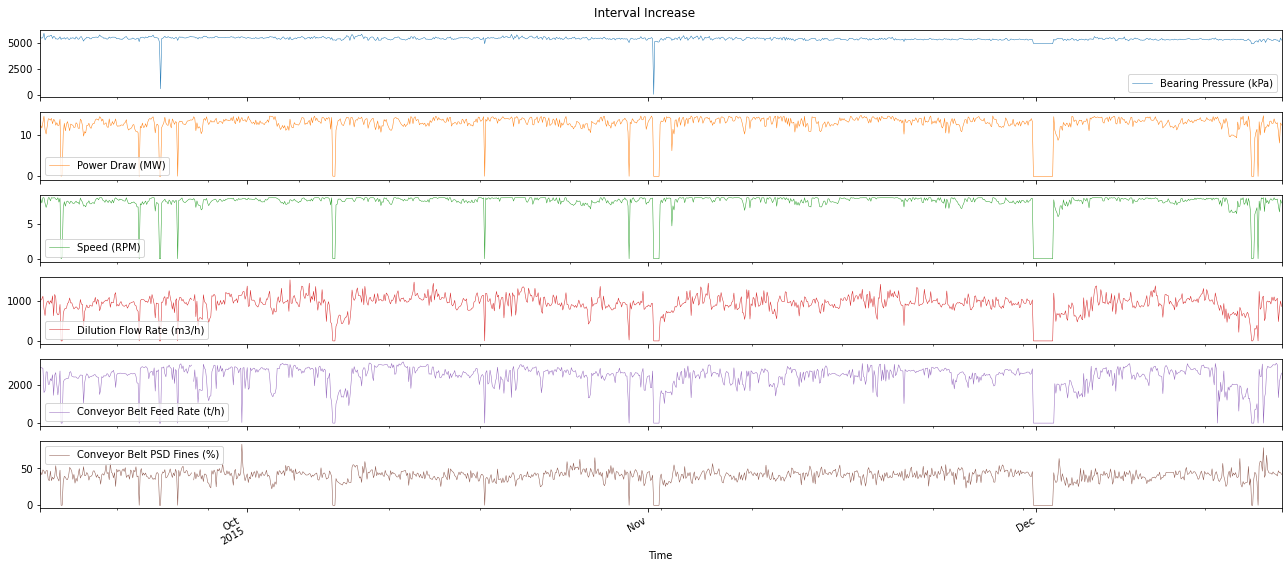

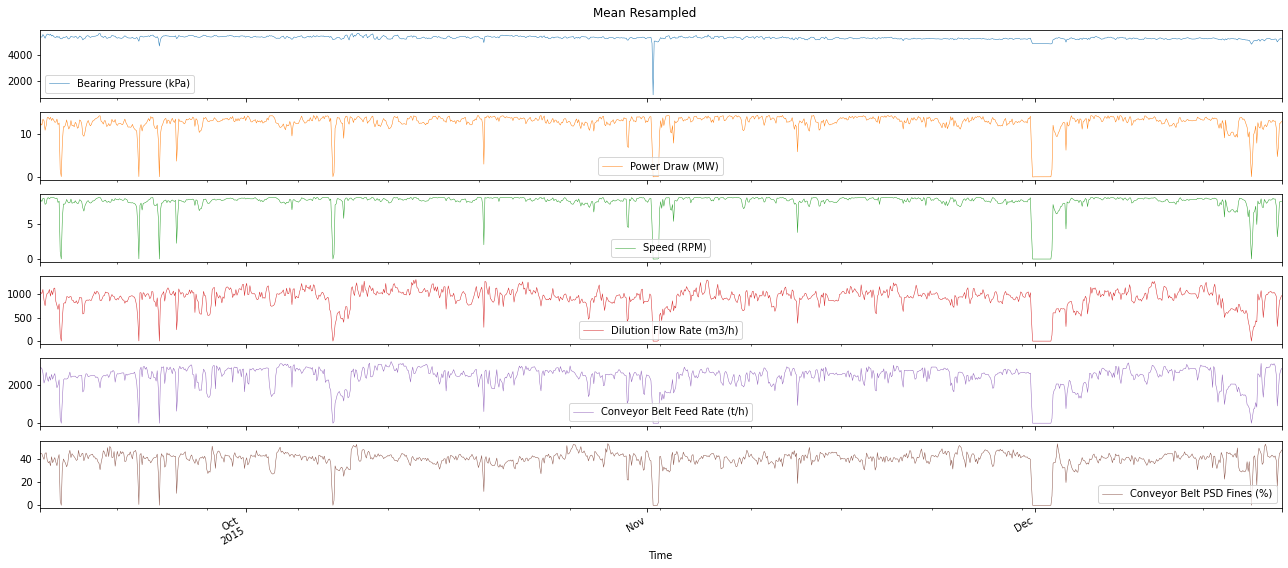

In [9]:
df_5min_interval_increase = df_train[::120-1] # 2hourly data
df_5min_interval_increase.plot(subplots=True, figsize=(18, 8), lw=0.5, title='Interval Increase')
plt.tight_layout()

df_5min_mean_resampled = df_train.resample('2H', loffset='1H').mean() #2 data centered on the mid-point interval
df_5min_mean_resampled.plot(subplots=True, figsize=(18, 8), lw=0.5, title='Mean Resampled')
plt.tight_layout()


The mean method here seems to smooth out the noisy data more, reducing the size of spikes.

Readjusting limits to give a more detailed look:

<ipython-input-10-7f06c5a3a470>:12: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  df_5min_mean_resampled = df_train.resample('2H', loffset='1H').mean() #2 data centered on the mid-point interval


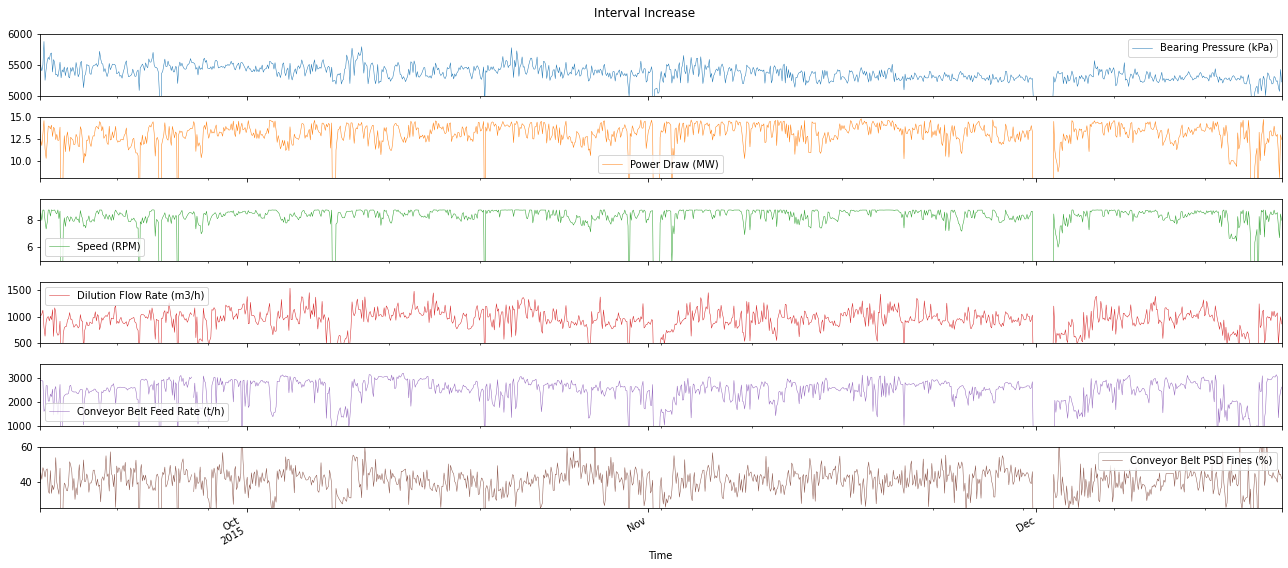

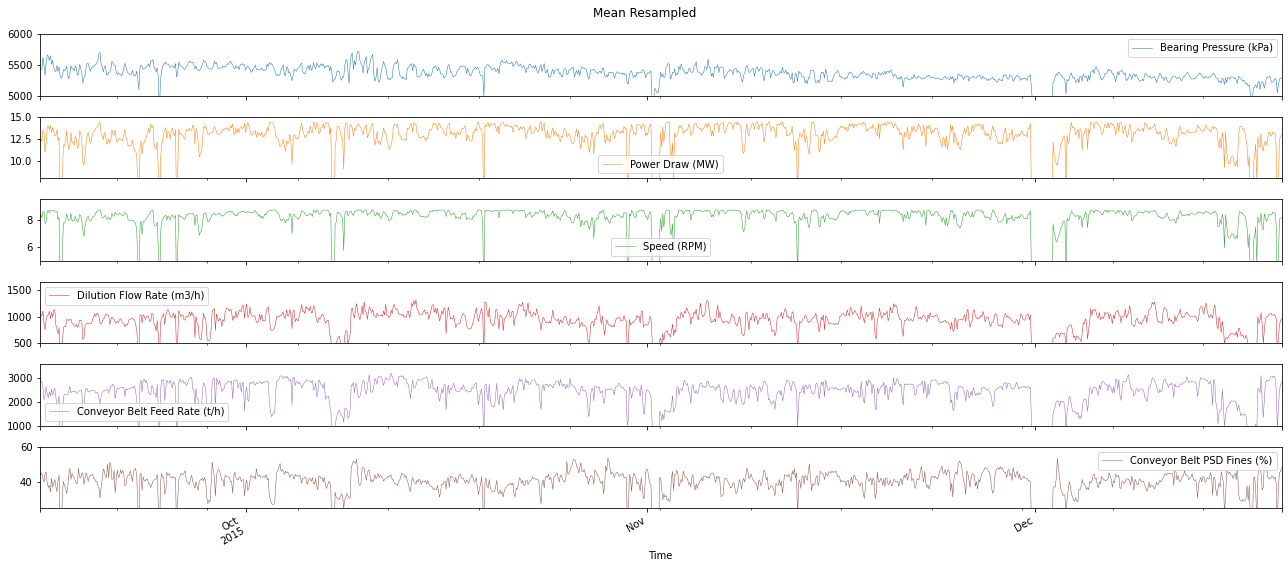

In [10]:

df_5min_interval_increase = df_train[::120-1] # 2hourly data
subplots_5min_interval = df_5min_interval_increase.plot(subplots=True, figsize=(18, 8), lw=0.5, title='Interval Increase')
subplots_5min_interval[0].set_ylim([5000,6000])
subplots_5min_interval[1].set_ylim([8,15])
subplots_5min_interval[2].set_ylim([5,9.5])
subplots_5min_interval[3].set_ylim([500,1650])
subplots_5min_interval[4].set_ylim([1000,3600])
subplots_5min_interval[5].set_ylim([25,60])
plt.tight_layout()


df_5min_mean_resampled = df_train.resample('2H', loffset='1H').mean() #2 data centered on the mid-point interval
subplots_5min_mean_resampled = df_5min_mean_resampled.plot(subplots=True, figsize=(18, 8), lw=0.5, title='Mean Resampled')
subplots_5min_mean_resampled[0].set_ylim([5000,6000])
subplots_5min_mean_resampled[1].set_ylim([8,15])
subplots_5min_mean_resampled[2].set_ylim([5,9.5])
subplots_5min_mean_resampled[3].set_ylim([500,1650])
subplots_5min_mean_resampled[4].set_ylim([1000,3600])
subplots_5min_mean_resampled[5].set_ylim([25,60])
plt.tight_layout()



* Localised peak around 2015-10-01 on Bearing Pressure, Power Draw and Speed coincide with localised dips on the other 3 features.
    * Other than this most of the time the graphs seem to exhibit some covariance.
* Data exhibits little regularity outside of consistently returning/oscillating around a consistent level and generally staying within limits.
    * This could be due to day to day events and/or variation in conditions contributing to the running of the machine similarly or more than the individual variables.

Thus, taking a random 1 week sample we get:

<ipython-input-11-d3e01d01c415>:5: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  week_5min_mean_resampled = df_train[0:10080-1].resample('5T', loffset='3T').mean() # 5minute mean data centered on the mid-point interval


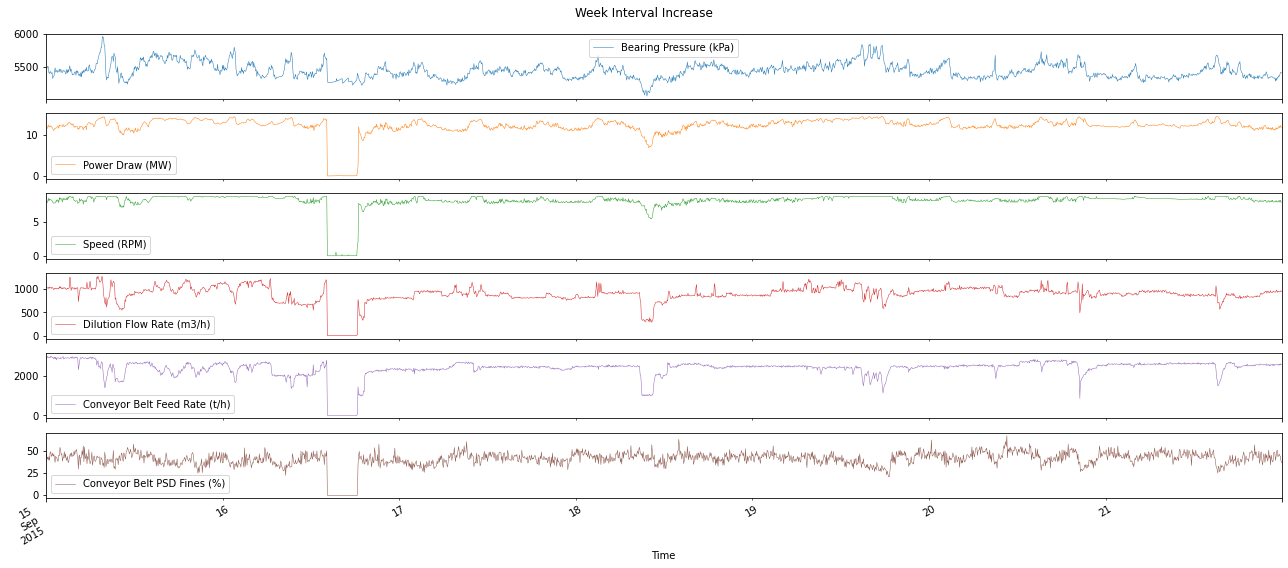

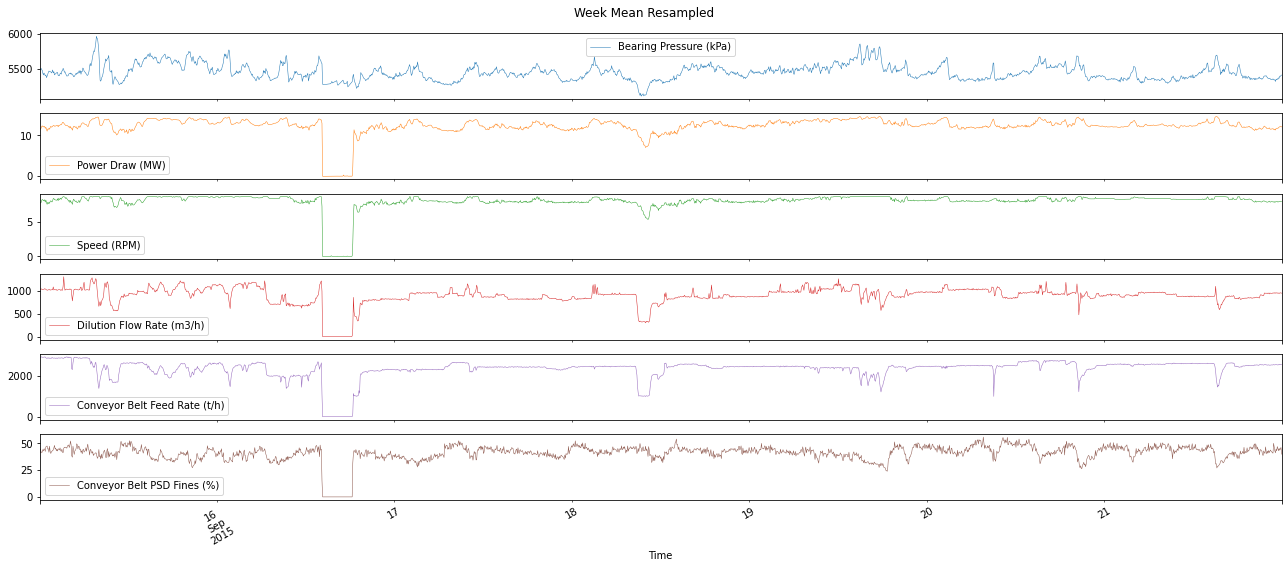

In [11]:
week_5min_interval_increase = df_train[0:10080-1:5] # 5 minute resampled week-long data from start
week_5min_interval_increase.plot(subplots=True, figsize=(18, 8), lw=0.5, title='Week Interval Increase')
plt.tight_layout()

week_5min_mean_resampled = df_train[0:10080-1].resample('5T', loffset='3T').mean() # 5minute mean data centered on the mid-point interval
week_5min_mean_resampled.plot(subplots=True, figsize=(18, 8), lw=0.5, title='Week Mean Resampled')
plt.tight_layout()

* Difference between the mean of resampled data and increased interval resampling is again minimal with mean smoothing over the details more.
* The system seems to have been powered down without emptying for a few hours of the second day.
    * When modelling, we will want to exclude or remove this period as it should have no predictive power
    * Manually changing the graph limits week by week we find that this even seems to happen regularly sometimes at the same time and sometimes at differing times for varying lengths of time.


From here, we will standardise the data to get a better idea of the overall distribution of all the variables. We can do this since the variables seem to stay within certain limits.

In [12]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

# Input numpy array
X_train = df_train.values

scaled_train = stdsc.fit_transform(X_train)

print(scaled_train)

[[ 0.62599974 -0.33975828 -0.10326614  0.4584346   0.80595086 -0.08928386]
 [ 0.30845173 -0.41199016 -0.20338427  0.49510266  0.79497945  0.57332138]
 [ 0.69461964 -0.55161407 -0.30690836  0.46889437  0.78119402 -0.08173689]
 ...
 [-0.50022047  0.27791048  0.24439948  0.07274669  0.71896589  0.09514355]
 [-0.58062377  0.17003952  0.14162652  0.14505795  0.72617196  0.84548328]
 [-0.39346135  0.14031847  0.08924522  0.22379894  0.69446383  0.84222584]]


In [13]:
# Convert numpy array to pandas dataframe
df_scaled_train = pd.DataFrame(scaled_train, columns=df_train.columns, index=df_train.index)

df_scaled_train.describe()

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
count,1.382400e+05,1.382400e+05,1.382410e+05,1.382390e+05,1.382390e+05,1.382390e+05
mean,5.763291e-15,-4.276415e-16,-8.322501e-16,-2.368493e-16,-8.421308e-16,1.858609e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.632438e+01,-4.746284e+00,-4.952911e+00,-3.613851e+00,-3.590187e+00,-3.967088e+00
25%,-3.614156e-01,-7.685697e-02,2.902803e-02,-2.784260e-01,-2.734355e-01,-3.101420e-01
50%,8.076492e-03,2.165126e-01,2.543988e-01,1.591350e-01,2.959558e-01,1.517083e-01
75%,4.417886e-01,4.833918e-01,4.125488e-01,5.431776e-01,6.282211e-01,5.349499e-01
max,3.134348e+00,8.648150e-01,4.448569e-01,2.852534e+00,1.791997e+00,4.537008e+00


* The means being non-zero here may be a result of overflowing values withing the calculations. 
    * In standardising, we have gone down in the number of significant digits for most cases and that would also contribute.

* Standard deviation is the same for all the features, this makes sense (again barring the overflow meaning the values aren't exactly 1)

* 

* Most of the variation is on the lower end of the features values.
    * We could see this on the graphs with how the points are more distributed under the oscilating values, with no points as far above as the points were far below.
    * 

Boxplot

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-09-15 00:00:00,0.626000,-0.339758,-0.103266,0.458435,0.805951,-0.089284
2015-09-15 00:01:00,0.308452,-0.411990,-0.203384,0.495103,0.794979,0.573321
2015-09-15 00:02:00,0.694620,-0.551614,-0.306908,0.468894,0.781194,-0.081737
2015-09-15 00:03:00,0.575026,-0.601771,-0.258635,0.476159,0.880587,0.334181
2015-09-15 00:04:00,0.724052,-0.458600,-0.139522,0.504268,0.760115,1.103283
...,...,...,...,...,...,...
2015-12-19 23:56:00,-0.348396,0.378267,0.431948,0.113297,0.717626,1.077118
2015-12-19 23:57:00,-0.269668,0.359266,0.366443,0.244154,0.623555,0.540964
2015-12-19 23:58:00,-0.500220,0.277910,0.244399,0.072747,0.718966,0.095144


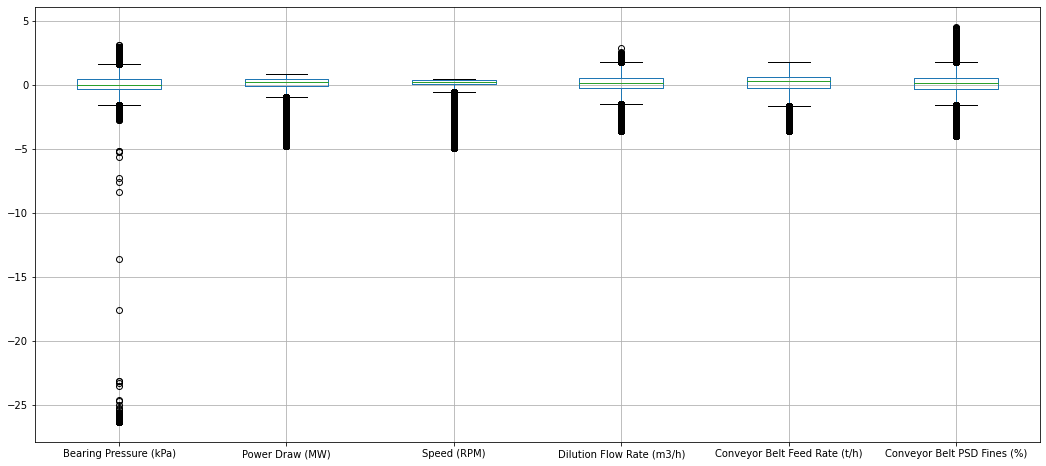

In [14]:
df_scaled_train.boxplot(figsize=(18,8))
# df_scaled_train.boxplot(layout=(2,1), by=df_train.index, figsize=(18,8))
df_scaled_train

Moving on to adding the target columns:

In [15]:
df_train['Future Bearing Pressure'] = df_train['Bearing Pressure (kPa)'].shift(periods=5)
df_train['Future Power Draw'] = df_train['Power Draw (MW)'].shift(periods=5)
df_train

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%),Future Bearing Pressure,Future Power Draw
Time,,,,,,,,
2015-09-15 00:00:00,5488.175540,11.737357,7.843532,1030.590108,2935.660276,38.641018,NaN,NaN
2015-09-15 00:01:00,5423.930126,11.543755,7.681607,1039.869847,2928.333772,45.243656,NaN,NaN
2015-09-15 00:02:00,5502.058523,11.169525,7.514173,1033.237205,2919.128115,38.716221,NaN,NaN
2015-09-15 00:03:00,5477.862749,11.035091,7.592248,1035.075573,2985.500811,42.860703,NaN,NaN
2015-09-15 00:04:00,5508.013201,11.418827,7.784895,1042.189406,2905.052105,50.524544,NaN,NaN
...,...,...,...,...,...,...,...,...
2015-12-19 23:56:00,5291.038653,13.661863,8.709156,943.244733,2876.678675,50.263821,5311.644590,13.595722
2015-12-19 23:57:00,5306.966515,13.610935,8.603212,976.361162,2813.859524,44.921227,5330.085622,13.352943
2015-12-19 23:58:00,5260.321858,13.392879,8.405826,932.982467,2877.573304,40.478775,5300.893807,12.989011


Now we can check the relations between the features and the targets. First we will check the correlation coefficients. The full correlation matrix will be shown to 

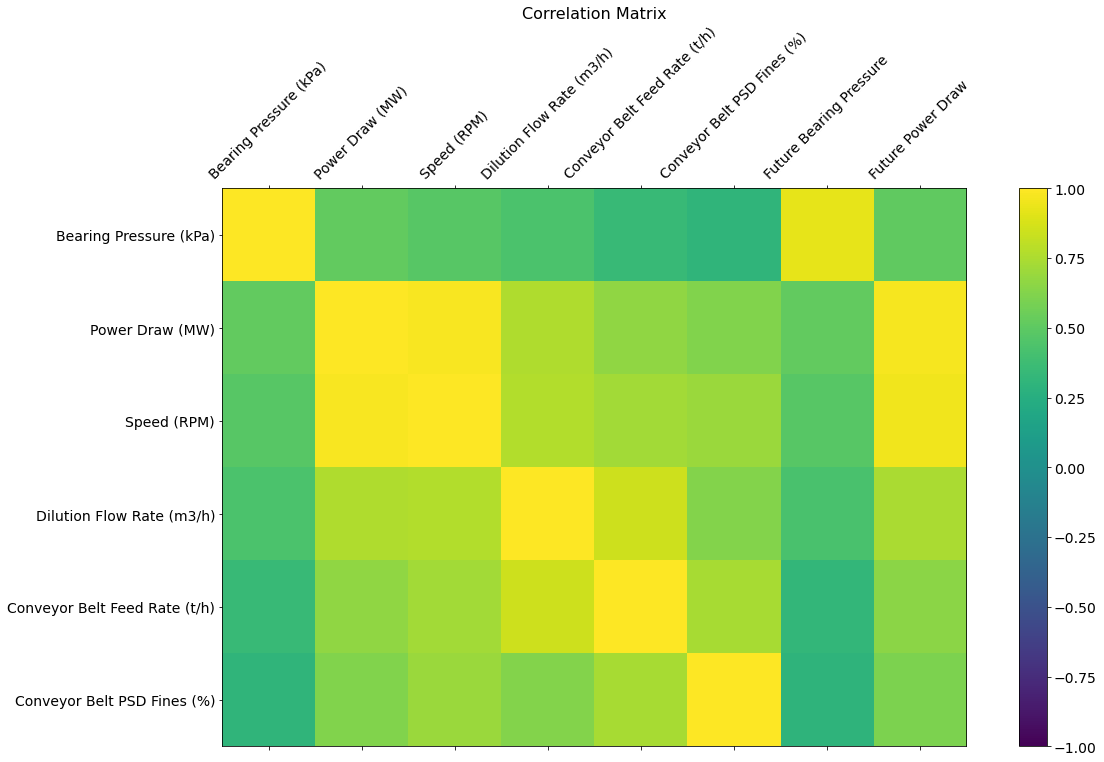

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%),Future Bearing Pressure,Future Power Draw
Bearing Pressure (kPa),1.000000,0.518896,0.484076,0.436871,0.344822,0.308349,0.928468,0.508801
Power Draw (MW),0.518896,1.000000,0.980499,0.760329,0.668028,0.623430,0.516383,0.976373
Speed (RPM),0.484076,0.980499,1.000000,0.766704,0.720555,0.696170,0.483669,0.958099
Dilution Flow Rate (m3/h),0.436871,0.760329,0.766704,1.000000,0.845888,0.626104,0.422650,0.742903
Conveyor Belt Feed Rate (t/h),0.344822,0.668028,0.720555,0.845888,1.000000,0.736723,0.324424,0.650140
Conveyor Belt PSD Fines (%),0.308349,0.623430,0.696170,0.626104,0.736723,1.000000,0.302540,0.607014


In [16]:
# Visualise correlation coefficients
f = plt.figure(figsize=(19,10))
corr_matrix = df_train.corr().drop('Future Bearing Pressure').drop('Future Power Draw') # Drop target variable rows so only features are on the left.
plt.matshow(corr_matrix, fignum=f.number, vmin=-1, vmax=1) # Set the colour scale to go over the full range of possible values with vmax and vmin.
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14, rotation=45)
plt.yticks(range(corr_matrix.shape[0]), corr_matrix.index, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

# Check actual values
df_train.corr()
corr_matrix

Among the feature + target correlation pairs, we have:

* Very strong positive correlation ( 0.9 <= r ):
    * Bearing Pressure + Future Bearing Pressure (0.928)
    * Power Draw + Future Power Draw (0.976)
    * Speed + Future Power Draw (0.958)
        * This is intuitive given, power draw is closely related to speed; especially at consistent mass levels.

* Strong positive correlation ( 0.7 <= r < 0.9 ):
    * Dilution Flow Rate + Future Power Draw (0.753)

* Moderate positive correlation ( 0.5 <= r < 0.7 ):
    * Bearing Pressure + Future Power Draw (0.509)
    * Power Draw + Future Bearing Pressure (0.516)
    * Conveyor Belt Feed Rate + Future Power Draw (0.650)
    * Conveyor Belt PSD Fines + Future Power Draw (0.607)

* Weak positive correlation ( 0.3 <= r < 0.5 ):
    * Conveyor Belt Feed Rate + Future Bearing Pressure (0.324)
    * Conveyor Belt PSD Fines + Future Bearing Pressure (0.303)
    * Speed + Future Bearing Pressure (0.484)
    * Dilution Flow Rate + Future Bearing Pressure (0.423)



Now the general shape of the entire dataset is known, we can move on to looking at a more relevant time scale for a 5 min prediction. We will start by looking at a 30 minute slice; Starting with a period from the first day:

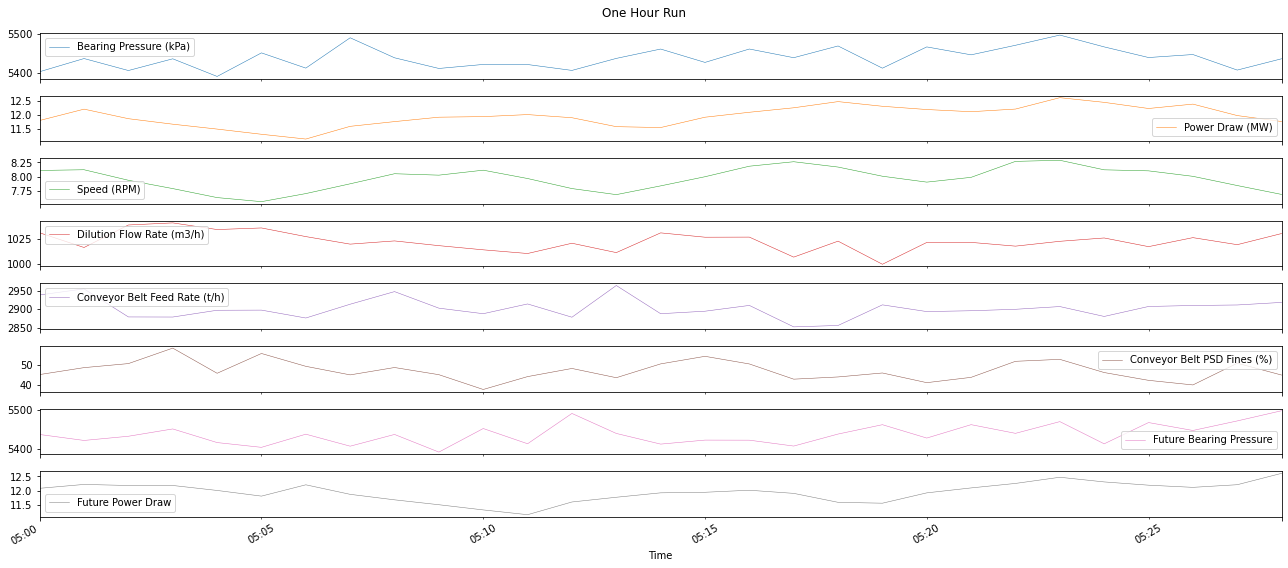

In [27]:
df_30min_interval = df_train[30*10:30*11-1] # Interval from 4th hour till 5th
df_30min_interval.plot(subplots=True, figsize=(18, 8), lw=0.5, title='One Hour Run')
plt.tight_layout()

* General 

correlation coefficients of the current half-hour:

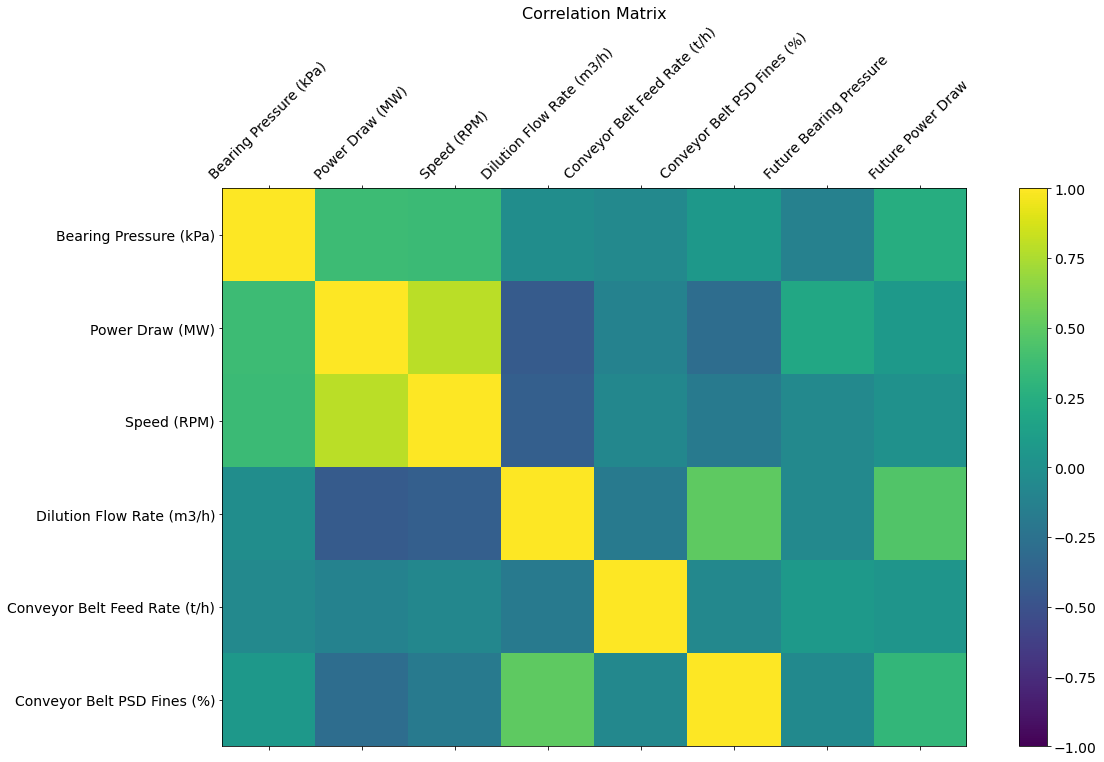

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%),Future Bearing Pressure,Future Power Draw
Bearing Pressure (kPa),1.000000,0.373417,0.359864,-0.016783,-0.056076,0.069167,-0.120723,0.245201
Power Draw (MW),0.373417,1.000000,0.792889,-0.423388,-0.109567,-0.284835,0.201392,0.083491
Speed (RPM),0.359864,0.792889,1.000000,-0.395500,-0.076454,-0.185094,-0.056947,0.010178
Dilution Flow Rate (m3/h),-0.016783,-0.423388,-0.395500,1.000000,-0.185520,0.505692,-0.059161,0.456218
Conveyor Belt Feed Rate (t/h),-0.056076,-0.109567,-0.076454,-0.185520,1.000000,-0.064693,0.071424,0.040871
Conveyor Belt PSD Fines (%),0.069167,-0.284835,-0.185094,0.505692,-0.064693,1.000000,-0.050065,0.326928


In [28]:
# Visualise correlation coefficients
f = plt.figure(figsize=(19,10))
corr_matrix = df_train[30*10:30*11-1].corr().drop('Future Bearing Pressure').drop('Future Power Draw') # Drop target variable rows so only features are on the left.
plt.matshow(corr_matrix, fignum=f.number, vmin=-1, vmax=1) # Set the colour scale to go over the full range of possible values with vmax and vmin.
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14, rotation=45)
plt.yticks(range(corr_matrix.shape[0]), corr_matrix.index, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

# Check actual values
df_train[30*10:30*11-1].corr()
corr_matrix

* Significant difference here to the overall trend
    * The bottom two variables now have  a neutral to weak negative correlation with the target variables.
    * None of the variables have a strong correlation with the target variables.
* Present speed still has a strong correlation with Power Draw as expected, albeit weaker than previously.
    * 